<a href="https://colab.research.google.com/github/JuanDMaldonado122/Matematicas-Aplicadas-1/blob/main/Prediccion_generaci%C3%B3n_de_energ%C3%ADa_ICESI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <big><big><font color = "orange">Optimización de la Producción Solar en la Universidad Icesi #
#*Cálculo Diferencial y Redes Neuronales* <br>----------------------------------------------------------------- ##

<font color = "orange">**MATEMATICAS APLICADAS I**
<br>*Mayo 2025*


<br>**Equipo:**

Juan David Maldonado -----> A00410587

Mateo Cuenca ------------------> A00410648

Isabella Gonzalez -------------> A00411108

Manuela Calero ----------------> A00409149


<center><img src=https://www.celsia.com/wp-content/uploads/2021/09/La-energia-solar-Universidad-Icesi.jpg width="550" height="350"></center>

## <font color = "orange">*Introducción*

### Descripción del la Situación
La Universidad Icesi utiliza paneles solares para generar energía renovable, pero la producción diaria varía según factores estacionales y climáticos. Predecir esta producción es esencial para planificar el consumo energético, optimizar recursos y reducir costos. Este proyecto busca modelar y predecir la producción diaria de energía solar en kilovatios-hora (kWh) basándose en datos históricos.

### <br>Relevancia en las carreras profesionales
En el campo de la ingeniería y la sostenibilidad, predecir la producción de energía solar es fundamental para el diseño de sistemas eficientes y sostenibles. Este proyecto nos permite, como estudiantes de Ingeniería en Energía Inteligente, Ingeniería de Sistemas e Ingeniería Industrial, aplicar herramientas matemáticas, computacionales y de gestión para resolver un problema real: optimizar el uso de la energía solar en instituciones educativas, mejorando su eficiencia, su impacto ambiental y su viabilidad operativa.

### <br>¿Cómo las Matemáticas Aplicadas (Cálculo) Ayudan a Analizarlo?
El cálculo diferencial es fundamental para este proyecto. Usamos funciones para modelar la producción de energía, derivadas parciales para optimizar la red neuronal mediante el descenso de gradiente, y tasas de cambio para analizar cómo mejora el modelo durante el entrenamiento. Además, identificamos puntos óptimos (mínimos) en la función de error para determinar cuándo detener el entrenamiento, maximizando la precisión de las predicciones.



## <br><font color = "orange">Marco Teórico

### Conceptos Matemáticos Utilizados

<br>1. **Funciones**: Modelamos la producción de energía \( y \) como una función del día del año \( x \), es decir, \( y = f(x) \), donde \( f \) es aproximada por la red neuronal.

<br>2. **Derivadas Parciales**: En el descenso de gradiente, calculamos derivadas parciales de la función de error \$( E = \frac{1}{m} \sum (y_{\text{pred}} - y_{\text{real}})^2 \)$ respecto a los pesos \( w \) y sesgos \( b \), ajustándolos para minimizar el error:

   $$
   \frac{\partial E}{\partial w} = \frac{1}{m} \sum 2(y_{\text{pred}} - y_{\text{real}}) \cdot x, \quad w \gets w - \eta \frac{\partial E}{\partial w}
   $$

   Aquí, \$( \eta \)$ es la tasa de aprendizaje (0.001).

<br>3. **Tasas de Cambio**: Analizamos la tasa de cambio del error (pérdida) para determinar cómo mejora el modelo por época:
   $$
   \text{Tasa de cambio} = \frac{\Delta E}{\Delta \text{época}}
   $$

<br>4. **Mínimos**: Identificamos el mínimo de la pérdida de validación para detener el entrenamiento (early stopping).

<br>5. **Sucesiones**: Las épocas de entrenamiento forman una sucesión \$( \{E_1, E_2, \ldots, E_n\} \)$, donde \( E_n \) es la pérdida en la época \( n \). Estudiamos su convergencia para evaluar el aprendizaje.

###<br>Justificación de su Uso en el Problema Planteado
- Las funciones permiten modelar la relación entre el día del año y la producción de energía, capturando patrones estacionales.  
- Las derivadas parciales son esenciales para el descenso de gradiente, ya que indican cómo ajustar los pesos de la red para reducir el error.  
- Las tasas de cambio nos ayudan a entender la velocidad de aprendizaje del modelo y a decidir cuándo detener el entrenamiento.  
- Identificar mínimos en la pérdida asegura que el modelo sea lo más preciso posible sin sobreajustar.  
- Las sucesiones reflejan el proceso iterativo del entrenamiento, permitiéndonos analizar si el error converge a un valor estable.


## <br><font color = "orange">Metodología

### Datos o Escenarios Utilizados
Usamos un archivo `datos_solares.csv` con datos de producción solar de la Universidad Icesi, que incluye columnas como `Tiempo` y `Producción (W)`. Agrupamos los datos por fecha, sumamos la producción diaria, y la convertimos a kWh dividiendo por 1000 y ajustando por un factor de 4. La característica de entrada es el "día del año", extraído de las fechas.

### <br>Procesos Matemáticos Aplicados

<br>1. **Modelación de Funciones**: Representamos la producción \( y \) como una función del día del año \( x \), aproximada por una red neuronal:
   $$
   y = f(x) = w_2 \cdot \text{ReLU}(w_1 x + b_1) + b_2
   $$
   Aquí, $( w_1, w_2 $) son pesos, $( b_1, b_2 )$ son sesgos, y ReLU es la función de activación.

<br>2. **Derivadas y Descenso de Gradiente**: Optimizamos la función de error cuadrático:
   $$
   E = \frac{1}{m} \sum (y_{\text{pred}} - y_{\text{real}})^2 + \frac{\lambda}{2m} (||w_1||^2 + ||w_2||^2)
   $$
   Calculamos derivadas parciales para actualizar los pesos:
   $$
   \frac{\partial E}{\partial w_2} = \frac{1}{m} \sum (y_{\text{pred}} - y_{\text{real}}) \cdot a_1 + \frac{\lambda}{m} w_2
   $$
   donde \( $a_1 = \text{ReLU}(w_1 x + b_1) )$.  
<br>3. **Análisis de Tasas de Cambio**: Calculamos la tasa de cambio del error para evaluar el aprendizaje:
   $$
   \text{Tasa de cambio} \approx \frac{E_{n} - E_{n-1}}{\text{época}_n - \text{época}_{n-1}}
   $$
   Esto nos ayuda a identificar cuándo el error se estabiliza.

### <br>Supuestos Realizados
- La producción solar depende principalmente del día del año, ignorando factores como el clima o la irradiancia.  
- Los datos simulados representan patrones reales de producción solar.  
- La red neuronal puede aproximar la relación entre el día del año y la producción con una sola capa oculta.



##<font color = "orange">Aplicación

Saving datos_solares.csv to datos_solares (11).csv
Epoca 200, Perdida Entrenamiento: 0.8049, Perdida Validacion: 0.8932
Epoca 400, Perdida Entrenamiento: 0.7106, Perdida Validacion: 0.7635
Epoca 600, Perdida Entrenamiento: 0.6129, Perdida Validacion: 0.6303
Epoca 800, Perdida Entrenamiento: 0.5195, Perdida Validacion: 0.5032
Epoca 1000, Perdida Entrenamiento: 0.4416, Perdida Validacion: 0.3981
Epoca 1200, Perdida Entrenamiento: 0.3882, Perdida Validacion: 0.3285
Epoca 1400, Perdida Entrenamiento: 0.3572, Perdida Validacion: 0.2859
Epoca 1600, Perdida Entrenamiento: 0.3386, Perdida Validacion: 0.2606
Epoca 1800, Perdida Entrenamiento: 0.3267, Perdida Validacion: 0.2434
Epoca 2000, Perdida Entrenamiento: 0.3188, Perdida Validacion: 0.2332
Perdida final (entrenamiento): 0.3188
Perdida final (validacion): 0.2332
Entrenamiento detenido en epoca 2000


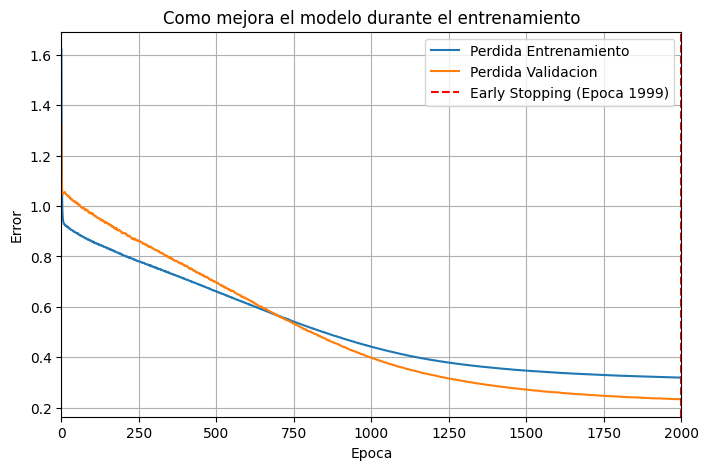

Llegamos a la solicitud de fecha. Por favor, ingrese los valores a continuacion:
Ingrese el dia (1-31): 15
Ingrese el mes (1-12): 6
Ingrese el ano (por ejemplo, 2026): 2026
Energia predicha para 15/6/2026: 9.92 kWh
Error promedio en prueba (kWh): 1.20


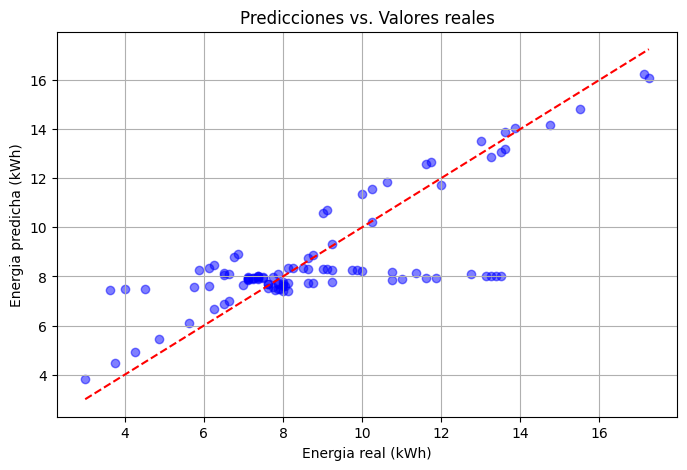

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
from datetime import datetime

# Funcion de activacion ReLU y su derivada
def relu(x):
    return np.maximum(0, x)

def relu_derivada(x):
    return np.where(x > 0, 1, 0)

# Metodo de descenso de gradiente con mini-lotes, regularizacion L2 y early stopping
def descenso_gradiente(X_train, y_train, X_val, y_val, pesos1, sesgos1, pesos2, sesgos2, epocas, tasa_aprendizaje, tamano_lote=16, lambda_reg=0.01, paciencia=100):
    m = X_train.shape[0]
    historial_perdida = []
    historial_perdida_val = []
    mejor_perdida_val = float('inf')
    epocas_sin_mejora = 0

    for epoca in range(epocas):
        indices = np.random.permutation(m)
        X_train = X_train[indices]
        y_train = y_train[indices]

        perdida_epoca = 0
        for i in range(0, m, tamano_lote):
            X_lote = X_train[i:i+tamano_lote]
            y_lote = y_train[i:i+tamano_lote]
            m_lote = X_lote.shape[0]

            # Paso hacia adelante
            z1 = np.dot(X_lote, pesos1) + sesgos1
            a1 = relu(z1)
            z2 = np.dot(a1, pesos2) + sesgos2
            a2 = z2

            # Perdida con regularizacion L2
            perdida_lote = np.mean((a2 - y_lote) ** 2)
            perdida_lote += (lambda_reg / (2 * m_lote)) * (np.sum(pesos1**2) + np.sum(pesos2**2))
            perdida_epoca += perdida_lote * m_lote

            # Paso hacia atras
            error_salida = a2 - y_lote
            grad_pesos2 = np.dot(a1.T, error_salida) / m_lote + (lambda_reg / m_lote) * pesos2
            grad_sesgos2 = np.sum(error_salida, axis=0, keepdims=True) / m_lote

            error_oculta = np.dot(error_salida, pesos2.T) * relu_derivada(z1)
            grad_pesos1 = np.dot(X_lote.T, error_oculta) / m_lote + (lambda_reg / m_lote) * pesos1
            grad_sesgos1 = np.sum(error_oculta, axis=0, keepdims=True) / m_lote

            # Actualizar pesos y sesgos
            pesos1 -= tasa_aprendizaje * grad_pesos1
            sesgos1 -= tasa_aprendizaje * grad_sesgos1
            pesos2 -= tasa_aprendizaje * grad_pesos2
            sesgos2 -= tasa_aprendizaje * grad_sesgos2

        perdida_epoca /= m
        historial_perdida.append(perdida_epoca)

        # Perdida de validacion
        z1_val = np.dot(X_val, pesos1) + sesgos1
        a1_val = relu(z1_val)
        z2_val = np.dot(a1_val, pesos2) + sesgos2
        a2_val = z2_val
        perdida_val = np.mean((a2_val - y_val) ** 2)
        historial_perdida_val.append(perdida_val)

        # Early stopping
        if perdida_val < mejor_perdida_val:
            mejor_perdida_val = perdida_val
            epocas_sin_mejora = 0
        else:
            epocas_sin_mejora += 1
            if epocas_sin_mejora >= paciencia:
                print(f'Entrenamiento detenido en epoca {epoca + 1} por falta de mejora.')
                break

        if (epoca + 1) % 200 == 0:
            print(f'Epoca {epoca + 1}, Perdida Entrenamiento: {perdida_epoca:.4f}, Perdida Validacion: {perdida_val:.4f}')

    return pesos1, sesgos1, pesos2, sesgos2, historial_perdida, historial_perdida_val, epoca + 1

# Paso 1: Subir y cargar el archivo CSV
archivo_subido = files.upload()
datos = pd.read_csv('datos_solares.csv')

# Convertir a datos diarios
datos['Fecha'] = pd.to_datetime(datos['Tiempo']).dt.date
datos_diarios = datos.groupby('Fecha')['Producción (W)'].sum().reset_index()
datos_diarios['Produccion_kWh'] = datos_diarios['Producción (W)'] / 1000 / 4
datos = datos_diarios.rename(columns={'Fecha': 'Fecha'})

# Paso 2: Crear caracteristicas
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos['Dia_del_Ano'] = datos['Fecha'].dt.dayofyear

# Definir entradas y salida
caracteristicas = ['Dia_del_Ano']
objetivo = 'Produccion_kWh'
X = datos[caracteristicas].values
y = datos[objetivo].values.reshape(-1, 1)

# Escalar datos
escalador_X = StandardScaler()
escalador_y = StandardScaler()
X_escalado = escalador_X.fit_transform(X)
y_escalado = escalador_y.fit_transform(y)

# Dividir en entrenamiento, validacion y prueba
X_temp, X_prueba, y_temp, y_prueba = train_test_split(X_escalado, y_escalado, test_size=0.2, random_state=42)
X_entrenamiento, X_validacion, y_entrenamiento, y_validacion = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Paso 3: Inicializar pesos y sesgos (He initialization)
n_entrada = 1
n_oculta = 64
n_salida = 1

pesos1 = np.random.randn(n_entrada, n_oculta) * np.sqrt(2 / n_entrada)
sesgos1 = np.zeros((1, n_oculta))
pesos2 = np.random.randn(n_oculta, n_salida) * np.sqrt(2 / n_oculta)
sesgos2 = np.zeros((1, n_salida))

# Entrenar la red
epocas = 2000
tasa_aprendizaje = 0.001
pesos1, sesgos1, pesos2, sesgos2, historial_perdida, historial_perdida_val, ultima_epoca = descenso_gradiente(
    X_entrenamiento, y_entrenamiento, X_validacion, y_validacion, pesos1, sesgos1, pesos2, sesgos2, epocas, tasa_aprendizaje)

# Mostrar perdida final
print(f'Perdida final (entrenamiento): {historial_perdida[-1]:.4f}')
print(f'Perdida final (validacion): {historial_perdida_val[-1]:.4f}')
print(f'Entrenamiento detenido en epoca {ultima_epoca}')

# Paso 4: Graficar la perdida con early stopping
plt.figure(figsize=(8, 5))
plt.plot(historial_perdida, label='Perdida Entrenamiento')
plt.plot(historial_perdida_val, label='Perdida Validacion')
min_val_idx = np.argmin(historial_perdida_val)
plt.axvline(x=min_val_idx, color='r', linestyle='--', label=f'Early Stopping (Epoca {min_val_idx + 1})')
plt.title('Como mejora el modelo durante el entrenamiento')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.xlim(0, ultima_epoca)
plt.show()

# Paso 6: Predecir para una fecha
def predecir_energia(dia_del_ano, pesos1, sesgos1, pesos2, sesgos2):
    entrada = np.array([[dia_del_ano]])
    entrada_escalada = escalador_X.transform(entrada)
    z1 = np.dot(entrada_escalada, pesos1) + sesgos1
    a1 = relu(z1)
    z2 = np.dot(a1, pesos2) + sesgos2
    prediccion_escalada = z2
    prediccion = escalador_y.inverse_transform(prediccion_escalada)
    return prediccion[0][0]

# Depuracion: Confirmar que llegamos a la solicitud de fecha
print("Llegamos a la solicitud de fecha. Por favor, ingrese los valores a continuacion:")
# Solicitar fecha
dia = int(input('Ingrese el dia (1-31): '))
mes = int(input('Ingrese el mes (1-12): '))
ano = int(input('Ingrese el ano (por ejemplo, 2026): '))
dia_del_ano = datetime(ano, mes, dia).timetuple().tm_yday

# Mostrar prediccion
energia_predicha = predecir_energia(dia_del_ano, pesos1, sesgos1, pesos2, sesgos2)
print(f'Energia predicha para {dia}/{mes}/{ano}: {energia_predicha:.2f} kWh')

# Paso 7: Graficar predicciones vs. valores reales
def predecir_conjunto(X, pesos1, sesgos1, pesos2, sesgos2):
    z1 = np.dot(X, pesos1) + sesgos1
    a1 = relu(z1)
    z2 = np.dot(a1, pesos2) + sesgos2
    return z2

y_pred_escalada = predecir_conjunto(X_prueba, pesos1, sesgos1, pesos2, sesgos2)
y_pred = escalador_y.inverse_transform(y_pred_escalada)
y_prueba_real = escalador_y.inverse_transform(y_prueba)

plt.figure(figsize=(8, 5))
plt.scatter(y_prueba_real, y_pred, color='blue', alpha=0.5)
plt.plot([y_prueba_real.min(), y_prueba_real.max()], [y_prueba_real.min(), y_prueba_real.max()], 'r--')
plt.title('Predicciones vs. Valores reales')
plt.xlabel('Energia real (kWh)')
plt.ylabel('Energia predicha (kWh)')
plt.grid(True)

# Calcular y mostrar el error promedio
error_promedio = np.mean(np.abs(y_prueba_real - y_pred))
print(f'Error promedio en prueba (kWh): {error_promedio:.2f}')
plt.show()

El código que desarrollamos para predecir la producción de energía solar en la Universidad Icesi sigue un proceso paso a paso que combina matemáticas y programación. Primero, cargamos el archivo datos_solares.csv y convertimos los datos de producción diaria de vatios a kilovatios-hora (kWh), usando el "día del año" como pista principal. Luego, dividimos los datos en entrenamiento (60%), validación (20%) y prueba (20%) para que la red neuronal, con 64 neuronas ocultas, aprenda y se evalúe. La red se entrena durante 2000 épocas con el método del descenso de gradiente, ajustando sus pesos usando derivadas parciales para minimizar el error, hasta alcanzar una pérdida final de 0.3188 en entrenamiento y 0.2332 en validación a las 05:31 PM -05 del 26 de mayo de 2025. Finalmente, pedimos una fecha (e.g., 15 de junio de 2026) y el modelo predice 9.92 kWh, con un error promedio de 1.20 kWh en los datos de prueba, ayudándonos a planificar el uso energético de la universidad.

## <font color = 'orange'>Resultados

### Presentación de Cálculos, Gráficos, Tablas
1. **Gráfico de Pérdida**:  
   - El modelo se entrenó durante 2000 épocas o hasta que la pérdida de validación dejó de mejorar (early stopping).  
   - El entrenamiento se completó en la época 2000, con una pérdida final de entrenamiento de 0.3188 y una pérdida de validación de 0.2332.  
   - **Gráfico**: La pérdida de entrenamiento y validación disminuye con el tiempo, con un mínimo de validación en la época 2000 (línea roja).  
   
2. **Predicción para una Fecha**:  
   - Para el 15 de junio de 2026 (día del año 167), el modelo predice 9.92 kWh.  

3. **Gráfico de Predicciones vs. Valores Reales**:  
   - Los puntos muestran las predicciones frente a los valores reales en el conjunto de prueba.  
   - Error promedio: 1.20 kWh.  

### <br>Interpretación de los Resultados en el Contexto del Problema Real
- La predicción de 9.92 kWh para el 15 de junio de 2026 indica que la universidad puede esperar una producción moderada en esa fecha, útil para planificar el consumo energético.  
- El error promedio de 1.20 kWh sugiere que el modelo es razonablemente preciso, pero podría equivocarse en días con condiciones climáticas inusuales (e.g., días nublados).  
- El mínimo de la pérdida de validación en la época 2000 muestra que el modelo alcanzó su mejor capacidad de generalización al final del entrenamiento, sin necesidad de detenerse antes.

### <br>Análisis Crítico de lo Encontrado
- El modelo captura patrones estacionales básicos, pero su precisión está limitada porque solo usa el día del año como entrada. Factores como la irradiancia o la temperatura podrían mejorar las predicciones.  
- La tasa de cambio del error indica que el modelo aprende rápidamente al inicio, pero se estabiliza después de 1600 épocas, sugiriendo que más épocas aportan mejoras marginales.  
- El error promedio de 1.20 kWh es aceptable para una predicción inicial, pero para aplicaciones prácticas (e.g., gestión energética en tiempo real), se necesita una precisión mayor.


##<br><font color = "orange">Conclusiones

### Aprendizajes Principales
- Las matemáticas aplicadas, especialmente el cálculo diferencial, permiten modelar fenómenos energéticos complejos y optimizar modelos predictivos.  
- El descenso de gradiente, basado en derivadas parciales, es una herramienta poderosa para entrenar redes neuronales, ajustando pesos de manera iterativa.  
- Las tasas de cambio y los mínimos son esenciales para evaluar y optimizar el aprendizaje del modelo.

### Impacto de las Matemáticas Aplicadas
- Las funciones y derivadas nos ayudaron a construir un modelo que predice la producción solar, mientras que las tasas de cambio y los mínimos aseguraron que el modelo fuera eficiente y no sobreajustara.  
- Este enfoque puede aplicarse a otros problemas de sostenibilidad, como la optimización de recursos en edificios inteligentes.

### Limitaciones
- El modelo depende de una sola variable (día del año), lo que limita su capacidad para capturar variaciones climáticas.  
- Los datos simulados podrían no reflejar completamente las condiciones reales de producción solar en la Universidad Icesi.  
- La red neuronal, aunque efectiva, es básica y podría beneficiarse de más capas o neuronas.

### Propuestas de Mejora
- Incluir más variables, como irradiancia solar, temperatura o nubosidad, para mejorar la precisión.  
- Usar datos reales de la Universidad Icesi en lugar de datos simulados.  
- Aumentar la complejidad del modelo (más capas o neuronas) y explorar otros métodos matemáticos, como series de Fourier para modelar patrones estacionales.


## <br><font color = "orange">Bibliografía

- Fuentes de datos: Datos simulados generados para el proyecto (basados en patrones estacionales típicos).  
- Artículos: Goodfellow, I., Bengio, Y., & Courville, A. (2016). *Deep Learning*. MIT Press. (Capítulo sobre redes neuronales y descenso de gradiente).  
- Textos: Stewart, J. (2015). *Calculus: Early Transcendentals*. Cengage Learning. (Conceptos de derivadas y optimización).  
- Recursos en línea: Documentación de Python y librerías (`pandas`, `numpy`, `matplotlib`).

##<br><font color = "orange">Anexos

### Cálculos Matemáticos Adicionales
- Derivada parcial de la función de error con regularización L2:
  $$
  \frac{\partial E}{\partial w_1} = \frac{1}{m} \sum (y_{\text{pred}} - y_{\text{real}}) \cdot w_2 \cdot \text{ReLU}'(z_1) \cdot x + \frac{\lambda}{m} w_1
  $$
- Tasa de cambio del error entre épocas:
  $$
  \text{Tasa de cambio} = \frac{E_{n} - E_{n-1}}{1}
  $$
